<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Leitura-dos-dados-de-chamadas" data-toc-modified-id="Leitura-dos-dados-de-chamadas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Leitura dos dados de chamadas</a></span><ul class="toc-item"><li><span><a href="#Coluna-1:-faixa-de-hora-no-dia" data-toc-modified-id="Coluna-1:-faixa-de-hora-no-dia-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Coluna 1: faixa de hora no dia</a></span></li><li><span><a href="#Coluna-2:-tipo-de-dia" data-toc-modified-id="Coluna-2:-tipo-de-dia-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Coluna 2: tipo de dia</a></span></li><li><span><a href="#Coluna-3:-bairro" data-toc-modified-id="Coluna-3:-bairro-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Coluna 3: bairro</a></span></li><li><span><a href="#Coluna-4:-prioridade-da-chamada" data-toc-modified-id="Coluna-4:-prioridade-da-chamada-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Coluna 4: prioridade da chamada</a></span></li><li><span><a href="#Coluna-5:-ocorrência" data-toc-modified-id="Coluna-5:-ocorrência-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Coluna 5: ocorrência</a></span></li></ul></li><li><span><a href="#Criar-classe-do-modelo" data-toc-modified-id="Criar-classe-do-modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Criar classe do modelo</a></span></li><li><span><a href="#Treinar-por-100-epochs" data-toc-modified-id="Treinar-por-100-epochs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Treinar por 100 epochs</a></span></li><li><span><a href="#Avaliar-evolução-dos-parâmetros" data-toc-modified-id="Avaliar-evolução-dos-parâmetros-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Avaliar evolução dos parâmetros</a></span></li></ul></div>

In [27]:
import sys
import torch
import numpy as np  

from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable

import matplotlib.pyplot as plt

In [28]:
sys.path.append('../../..')
from config import *
from utils import *

# Leitura dos dados

In [29]:
df = pd.read_pickle(os.path.join(TRTD_DATA_PATH,'eventos.pkl'))
df.head()

,data_idx,Prioridade,TotalViaturas,latitude,longitude,data,hora,p,Coordenadas,g,lat,lon,geometry,i,nome_bairro,Área,area,t
1,2016-01-01 02:13:00,0,1,-22.876186,-43.675890,2016-01-01,2:13:05,1,POINT (-43.67589 -22.876186),1,-43.675890,-22.876186,POINT (-43.67589 -22.87619),149,Santa Cruz,1.250443e+08,1.250443e+08,5
3,2016-01-01 02:17:00,1,1,-22.906627,-43.293335,2016-01-01,2:17:06,2,POINT (-43.293335 -22.906627),1,-43.293335,-22.906627,POINT (-43.29333 -22.90663),66,Engenho De Dentro,3.920441e+06,3.920441e+06,5
6,2016-01-01 02:28:00,0,1,-23.012424,-43.541721,2016-01-01,2:28:08,1,POINT (-43.541721 -23.012424),1,-43.541721,-23.012424,POINT (-43.54172 -23.01242),152,Barra De Guaratiba,9.442031e+06,9.442031e+06,5
15,2016-01-01 02:51:00,0,2,-22.851838,-43.357152,2016-01-01,2:51:25,1,POINT (-43.357152 -22.851838),1,-43.357152,-22.851838,POINT (-43.35715 -22.85184),87,Honório Gurgel,1.374847e+06,1.374847e+06,6
20,2016-01-01 03:00:00,0,1,-22.824990,-43.392745,2016-01-01,3:00:47,1,POINT (-43.392745 -22.82499),1,-43.392745,-22.824990,POINT (-43.39274 -22.82499),107,Anchieta,4.345727e+06,4.345727e+06,7


In [30]:
vizinhancas = pd.read_csv(os.path.join(ENTR_DATA_PATH,'bairros_vizinhos.csv'),sep=';',encoding='latin-1',index_col=0)
vizinhancas.head()

,NOME,NEIGHBORS
0,Paquetá,NaN
1,Freguesia,Bancários
2,Bancários,"Freguesia, Tauá, Cocotá"
3,Galeão,"Portuguesa, Jardim Guanabara, Cidade Universit..."
4,Tauá,"Bancários, Moneró, Cocotá, Jardim Carioca"


# Tratamentos

In [31]:
# dropar paquetá
vizinhancas.drop(0,inplace=True)
df = df[df['i']!=0]

In [32]:
bairro_to_idx = df[['i','nome_bairro']].drop_duplicates().set_index('nome_bairro')['i'].to_dict()

vizinhancas['NOME'] = vizinhancas['NOME'].map(bairro_to_idx)
bairro_to_vizinhos = vizinhancas.set_index('NOME')['NEIGHBORS'].apply(lambda v:[bairro_to_idx[b.strip()] for b in v.split(',')]).to_dict()

In [33]:
idx_to_i = {idx:i for (i,idx) in enumerate(bairro_to_vizinhos.keys())}
i_to_idx = {i:idx for (i,idx) in enumerate(bairro_to_vizinhos.keys())}

In [34]:
N_BAIRROS = len(bairro_to_idx)

# Criar classe do modelo

In [9]:
p = 1
g = 1
t = 24

Y = np.zeros(shape=(N_BAIRROS,522))

for bairro,idx in tqdm(list(bairro_to_idx.items())):
    i = idx_to_i[idx]
    Y[i,:] = calcular_distribuicao(df,t,g,idx,p,tipo_discretizacao_temp=0)

100%|██████████| 159/159 [01:35<00:00,  1.66it/s]


In [40]:
Y = pd.read_csv('../../../distribuicoes.csv')

In [47]:
Y[Y['bairro']==101]['y'].mean()

0.005747126436781609

In [10]:
class ModelWithNoRegressors(nn.Module):
    def __init__(self,n,alpha_=1,eps=1e-8):
        super(ModelWithNoRegressors, self).__init__()
        
        self.alpha = alpha_
        self.eps = eps
        self.iter = 0
        self.params_hist = []
        
        self.linear1   = nn.Linear(1, n, bias=False)
        self.optimizer = optim.Adam(self.parameters(), lr=.5)
        
        self.linear1.weight.data.fill_(1)

    def forward(self,state=np.ones(1)):
        x = self.linear1(torch.from_numpy(state).float())
        x = torch.max(x,-x)
        for p in self.parameters():
            p.data = x.reshape(-1,1)
        return x
    
    def backward(self,Y: np.array,lambdas):
        
        self.iter += 1

        L = self.forward().detach()
        self.params_hist.append(L.numpy())
        
        Y = torch.tensor(Y)

        gradients = []
        for i,(eventos_bairro,l) in enumerate(zip(Y,lambdas)): #for Y, it assumes you're iterating collumns
            g = []
            idx = i_to_idx[i]
            # loop in j
            for y in eventos_bairro:
                verossimilhanca = l - y*torch.log(l)
                g.append(verossimilhanca)

            # termo regularizador
            vizinhos = bairro_to_vizinhos[idx]
            for vizinho_idx in vizinhos:
                vizinho_i = idx_to_i[vizinho_idx]
                vizinho_lambda = L[vizinho_i]
                reg = F.mse_loss(l,vizinho_lambda)*self.alpha

                g.append(reg.to(torch.float64))
                
            gradients.append(torch.stack(g).sum())
            
        self.optimizer.zero_grad()
        grad = torch.stack(gradients).sum()
        grad = grad / (self.iter)
        grad.backward()
        self.optimizer.step()

In [11]:
model = ModelWithNoRegressors(N_BAIRROS,.3)

In [12]:
n_epochs = 1000
for i in range(n_epochs):
    print(i,end='...')
    lambdas = model.forward()
    model.backward(Y,lambdas)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

# Avaliar evolução dos parâmetros

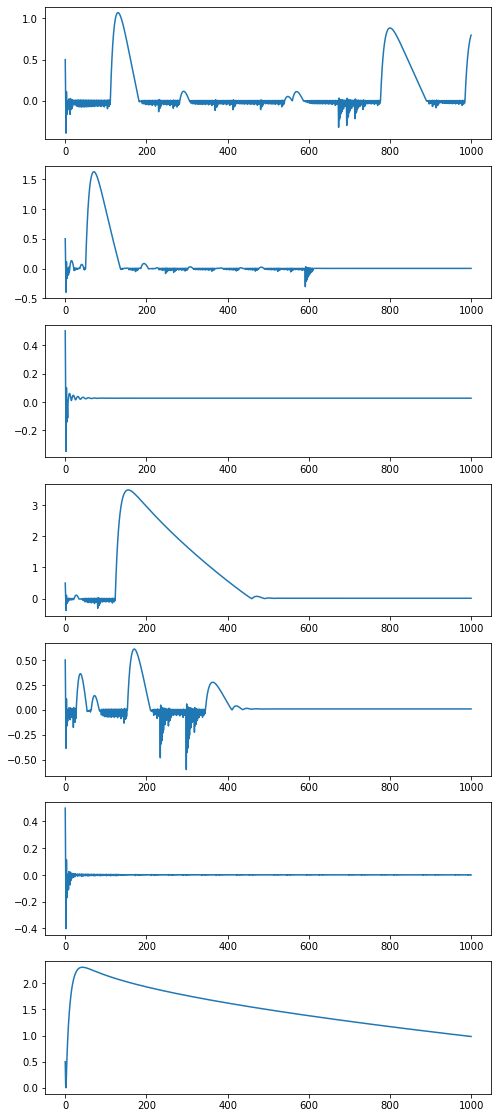

In [13]:
fig,axes = plt.subplots(nrows=7,ncols=1,figsize=(8,20))

for i,p in enumerate(np.array(model.params_hist).transpose()):
    try:
        axes[i].plot(p)
    except:
        break

In [14]:
f = model.forward()
f

tensor([7.9702e-01, 1.9176e-03, 2.6818e-02, 1.3409e-02, 9.5786e-03, 8.8273e-04,
        9.8153e-01, 1.3432e-02, 9.5456e-04, 1.3432e-02, 5.7472e-03, 1.9187e-02,
        2.4904e-02, 1.3410e-02, 1.5351e-02, 1.9262e-03, 1.7746e-03, 3.0740e-02,
        9.7818e-02, 7.6626e-03, 1.4199e+00, 2.6818e-02, 3.2563e+00, 1.9157e-03,
        3.8189e-04, 2.8780e-02, 3.6503e-02, 6.2338e-05, 7.6580e-04, 2.6961e-02,
        2.8733e-02, 7.7298e-03, 1.1495e-02, 3.8379e-03, 1.1601e-02, 9.4401e-04,
        1.1495e-02, 2.4977e-02, 1.9188e-02, 2.1073e-02, 7.6155e+00, 7.6631e-03,
        2.8871e-02, 2.6819e-02, 9.0859e-02, 1.5371e-02, 2.4903e-02, 1.9187e-02,
        4.2194e-02, 2.5588e+00, 1.5371e-02, 9.6079e-03, 2.2992e-02, 4.2273e-02,
        9.6384e-03, 2.4903e-02, 2.4975e-02, 1.1528e-02, 4.8334e-01, 1.2197e+00,
        2.7734e+00, 9.3850e-02, 1.1599e-02, 3.0705e-02, 1.1511e-02, 7.7299e-03,
        9.5789e-03, 9.5848e-03, 2.1878e-05, 1.3450e-02, 9.5788e-03, 2.1071e-02,
        2.6855e-02, 1.5326e-02, 9.5842e-

In [18]:
a,b = idx_to_i[bairro_to_idx['Copacabana']],idx_to_i[bairro_to_idx['Ipanema']]
f[a],f[b]

(tensor(0.0691, grad_fn=<SelectBackward>),
 tensor(0.0249, grad_fn=<SelectBackward>))

In [16]:
l1,l2 = [],[]
for p in model.parameters():
    for i,l in enumerate(p):
        # idx = idx_to_i[i]
        y = Y[i,:]
        if np.abs(l.detach().numpy()[0]-1e-8)<1e-8:
            l1.append(y.mean())
        else:
            l2.append(y.mean())

(array([13.,  5.,  7.,  9., 15., 13., 13.,  6., 10.,  3.,  0.,  6.,  3.,
         2., 12.,  9.,  8.,  2.,  2.,  1.,  0.,  1.,  1.,  1.,  3.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
         2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.00172414, 0.00344828, 0.00517241, 0.00689655,
        0.00862069, 0.01034483, 0.01206897, 0.0137931 , 0.01551724,
        0.01724138, 0.01896552, 0.02068966, 0.02241379, 0.02413793,
        0.02586207, 0.02758621, 0.02931034, 0.03103448, 0.03275862,
        0.03448276, 0.0362069 , 0.03793103, 0.03965517, 0.04137931,
        0.04310345, 0.04482759, 0.04655172, 0.04827586, 0.05      ,
        0.05172414, 0.0534

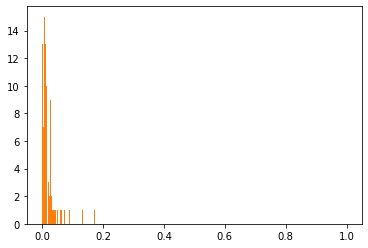

In [17]:
plt.hist(l1,bins=10)
plt.hist(l2,bins=100)